In [1]:
import sys
sys.path.insert(0, '../')
from data_preparation import *

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
import seaborn as sns
sns.set()



In [2]:
train_1 = pd.read_csv('../train_1.csv')

In [3]:
data = data_per_date(train_1)

In [4]:
data.set_index('Date').head()

,Page,Type_of_traffic,Agent,lang,count
Date,,,,,
2015-07-01,2NE1,all-access,spider,zh,18.0
2015-07-01,2PM,all-access,spider,zh,11.0
2015-07-01,3C,all-access,spider,zh,1.0
2015-07-01,4minute,all-access,spider,zh,35.0
2015-07-01,52_Hz_I_Love_You,all-access,spider,zh,NaN


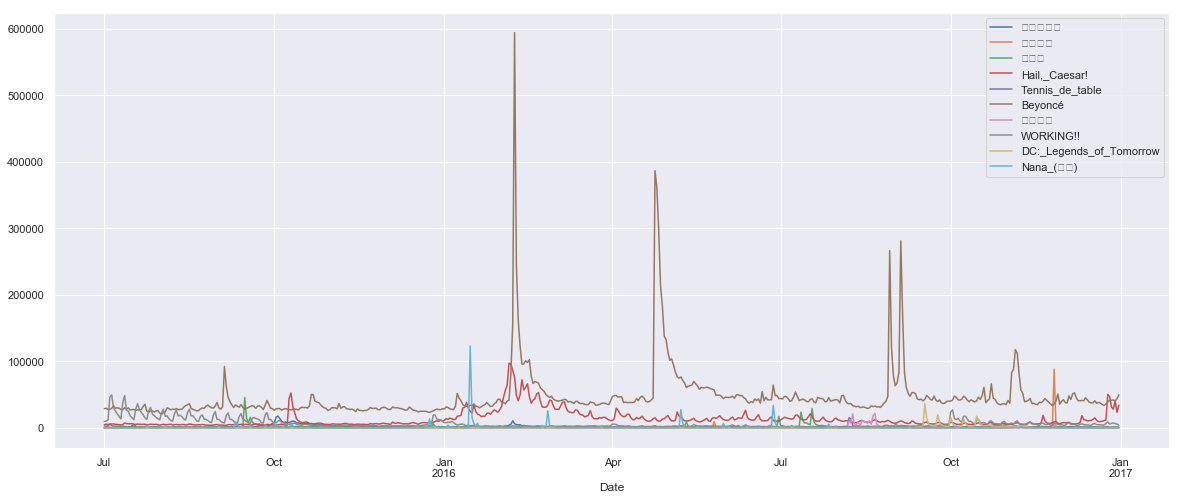

In [7]:
plot_random_series(data,10)

In [4]:
ML = find_page(data, 'Machine_learning')

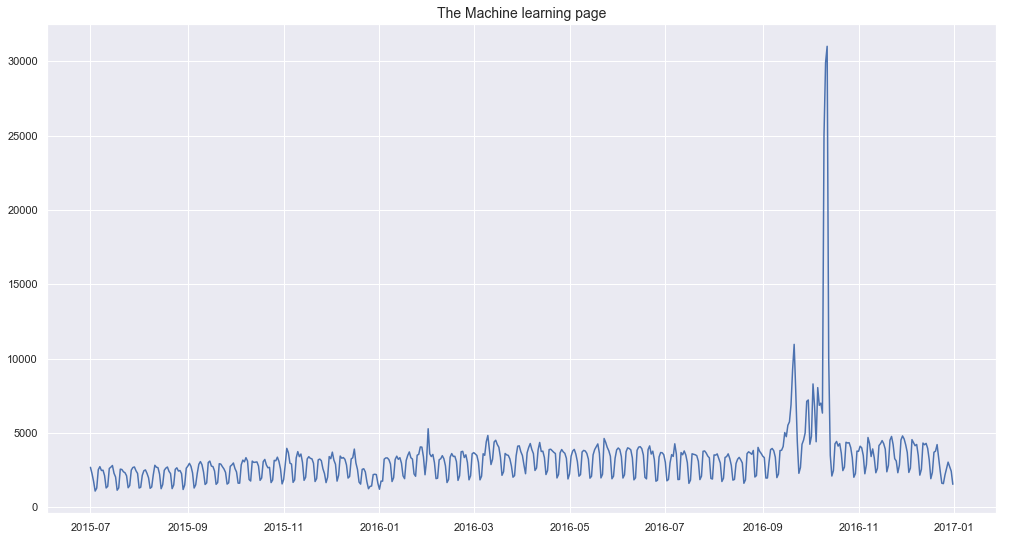

In [5]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.figure(figsize=(17, 9))
plt.plot(ML, color = 'b',linewidth=1.5)
plt.title('The Machine learning page', fontsize = 14)
plt.show()

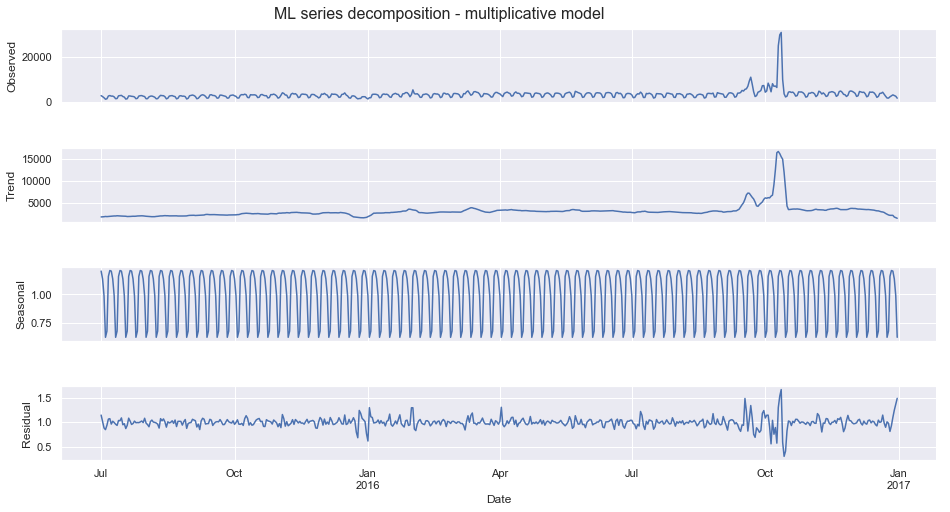

In [6]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(ML,freq=7, model = 'multiplicative', extrapolate_trend='freq')

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.suptitle('ML series decomposition - multiplicative model', fontsize = 16)
plt.show()

In [7]:
# evaluation of classical approach on training data
df = pd.concat([res.trend, res.seasonal, res.observed], axis=1)
df.columns = ['trend', 'seasonal', 'observed']
df = df.dropna()
df['pred'] = df['trend']*df['seasonal']
seasonal_coeff = df['seasonal']
df.head(8)

,trend,seasonal,observed,pred
Date,,,,
2015-07-01,1945.459184,1.203137,2687.0,2340.654689
2015-07-02,1970.515306,1.134594,2265.0,2235.735408
2015-07-03,1995.571429,0.988455,1742.0,1972.533517
2015-07-04,2047.714286,0.627613,1090.0,1285.171359
2015-07-05,2017.285714,0.681677,1291.0,1375.136657
2015-07-06,2050.000000,1.156786,2528.0,2371.411916
2015-07-07,2105.142857,1.207737,2731.0,2542.459360
2015-07-08,2135.142857,1.203137,2474.0,2568.870209


In [8]:
from arima_model import *

print("------------------")
print('Classical additive model SMAPE:{:10.4f}'.format(smape(df['observed'],df['pred'])))
print("------------------")

------------------
Classical additive model SMAPE:    6.6378
------------------


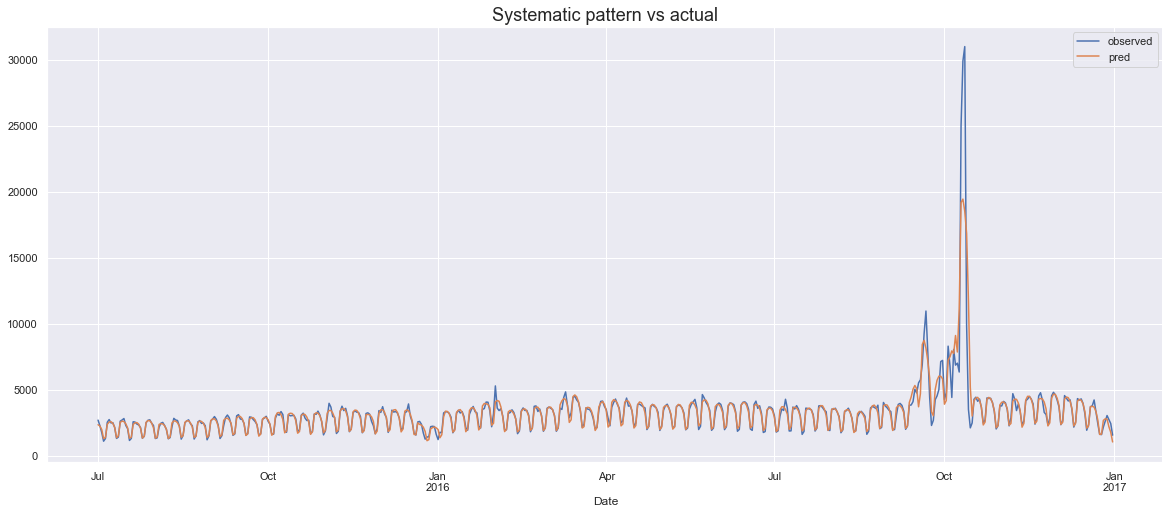

In [9]:
df[['observed','pred']].plot(figsize=(20, 8))
plt.title('Systematic pattern vs actual', fontsize = 18)
plt.show()

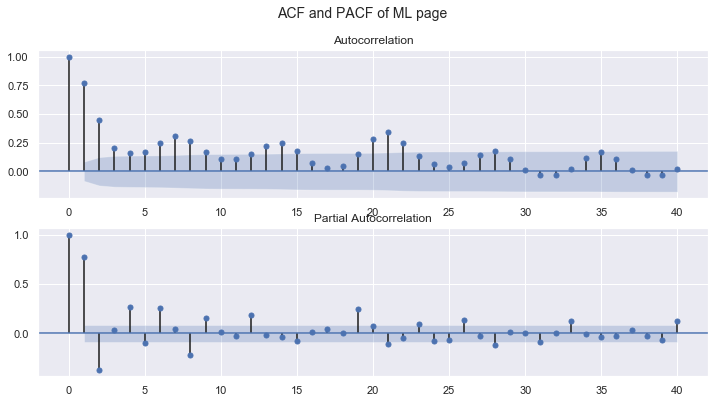

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))

ax[0] = plot_acf(ML['count'], lags = 40, ax=ax[0])
ax[1] = plot_pacf(ML['count'],lags = 40, ax=ax[1])
fig.suptitle('ACF and PACF of ML page', fontsize = 14)
plt.show()

In [11]:
df['deseasonalized'] = df['observed']/df['seasonal']
df.head()

,trend,seasonal,observed,pred,deseasonalized
Date,,,,,
2015-07-01,1945.459184,1.203137,2687.0,2340.654689,2233.327646
2015-07-02,1970.515306,1.134594,2265.0,2235.735408,1996.308308
2015-07-03,1995.571429,0.988455,1742.0,1972.533517,1762.345429
2015-07-04,2047.714286,0.627613,1090.0,1285.171359,1736.740052
2015-07-05,2017.285714,0.681677,1291.0,1375.136657,1893.859671


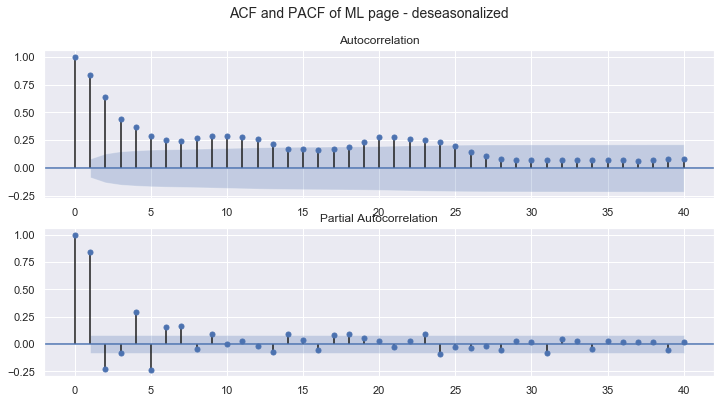

In [12]:
fig, ax = plt.subplots(2, figsize=(12,6))

ax[0] = plot_acf(df['deseasonalized'], lags = 40, ax=ax[0])
ax[1] = plot_pacf(df['deseasonalized'],lags = 40, ax=ax[1])
fig.suptitle('ACF and PACF of ML page - deseasonalized', fontsize = 14)
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller



result = adfuller(df['deseasonalized'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.390417
p-value: 0.000309
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [13]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
size = int(0.66*len(df['deseasonalized']))
resDiff = sm.tsa.arma_order_select_ic(df['deseasonalized'][:size],\
                                     max_ar=10, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 4) is the best.


In [5]:
from arima_model import *
#warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA

# size = int(0.80*len(ML))
#train, test = series_split(ML, size)

#train_deseasoned = aa.difference(train, 30)

# arima = sm.tsa.statespace.SARIMAX(train,order=(7,1,7),seasonal_order=(0,0,0,0),\
#                                   enforce_stationarity=False,\
#                                   enforce_invertibility=False,).fit()


train = df['deseasonalized'][0:size]
test = df['deseasonalized'][size:]
model = ARIMA(train, order=(7,0,4))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps = len(test))
pred = output[0]

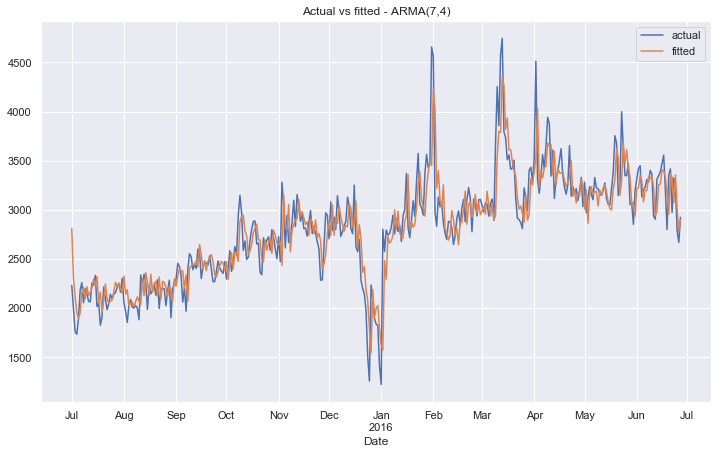

In [15]:
new = pd.DataFrame(
    {'actual': train,
    'fitted': model_fit.fittedvalues} 
     )
new.plot(figsize=(12, 7))
plt.title('Actual vs fitted - ARMA(7,4)')
plt.show()

In [40]:
from sklearn.metrics import mean_absolute_error

#pred = arima.predict(size+1, len(ML))

print("------------------")
print('ARIMA model SMAPE:{:10.4f}'.format(smape(test,pred)))
print("------------------")

------------------
ARIMA model SMAPE:   25.6907
------------------


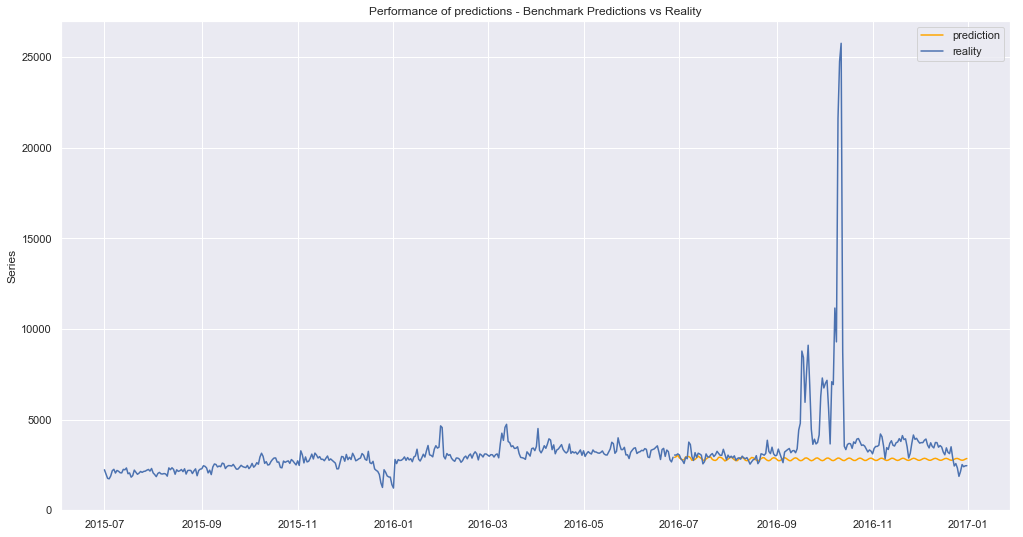

In [41]:
plot_arima(train, test, pred)

In [42]:
predictions = rolling_forecast(train, test, ARIMA, 1,0,0)
predictions = pd.DataFrame(predictions)

In [43]:
smape_mod = smape(test, predictions[0])
print ("-----------------------------------------------")
print ("ARIMA ROLLING FORECAST model smape:{:10.4f}".format(smape_mod))
print ("-----------------------------------------------")

-----------------------------------------------
ARIMA ROLLING FORECAST model smape:    9.7675
-----------------------------------------------


In [19]:
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape2(A, F):
    A, F = np.array(A), np.array(F)
    return np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))*100

def smape1(A, F):
    A, F = np.array(A), np.array(F)
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

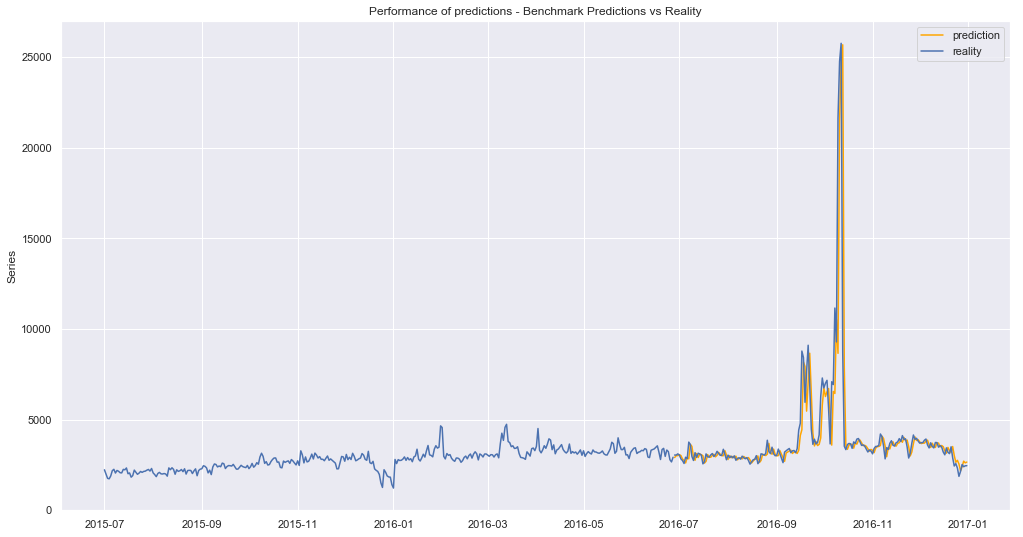

In [44]:
plot_arima(train, test, predictions)

## VAR Model

In [45]:
page = divide_page_by_lang(data, 'ASCII')

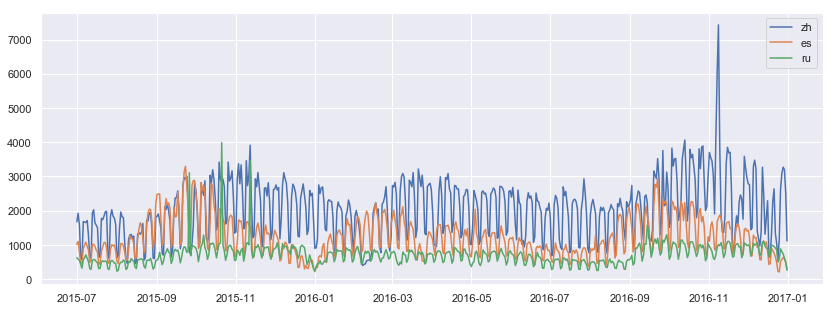

In [46]:
for key in page.columns:
    fig = plt.figure(1,figsize=[14,5])
    plt.plot(page[key], label = key , linewidth = 1.5)
    
plt.legend()
plt.show()

In [47]:
train_size = int(0.66*page.shape[0])
train = page.iloc[:train_size,:]
test = page.iloc[train_size:, :]

In [48]:
from statsmodels.tsa.api import VAR
history = train.copy()
predictions = pd.DataFrame(columns=train.columns)
    
model = VAR(history)
model_fit = model.fit(maxlags=20, ic='aic')
lag_order = model_fit.k_ar
output = model_fit.forecast(test.values[:], steps = test.shape[0])
pred = output
        

In [49]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Jul, 2019
Time:                     21:37:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    35.1915
Nobs:                     346.000    HQIC:                   34.1478
Log likelihood:          -7104.96    FPE:                3.41418e+14
AIC:                      33.4572    Det(Omega_mle):     2.24319e+14
--------------------------------------------------------------------
Results for equation zh
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        104.410179       120.313913            0.868           0.385
L1.zh          0.585516         0.060076            9.746           0.000
L1.es         -0.091588         0.103948           -0.881           0.378
L1.ru         -0.

In [50]:
pred = pd.DataFrame(pred)
pred.columns = test.columns


In [51]:
pred.index = test.index

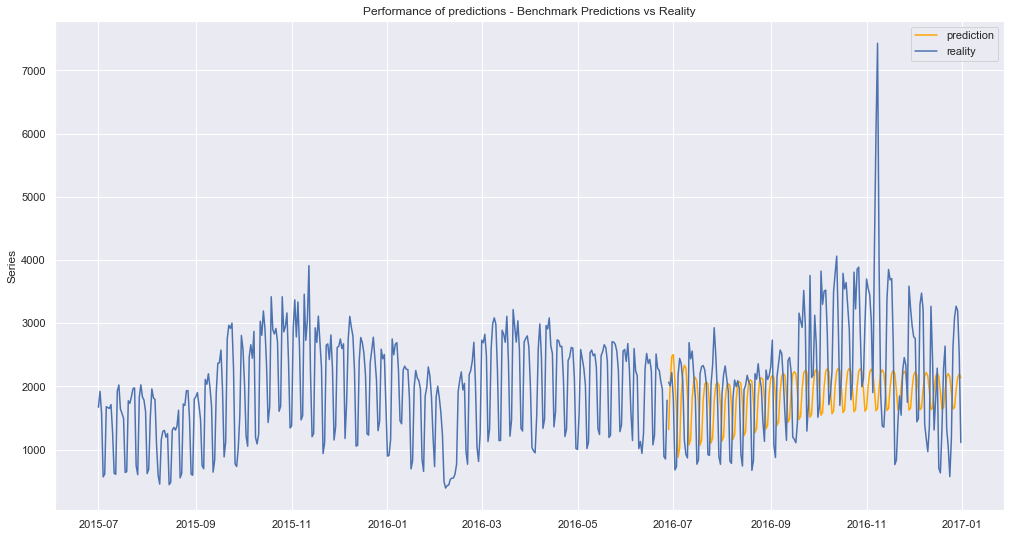

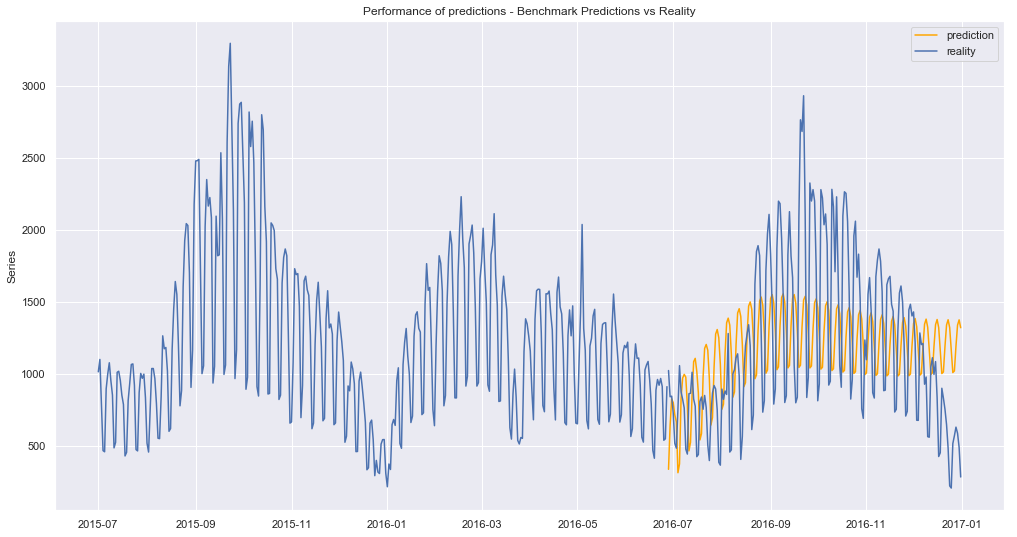

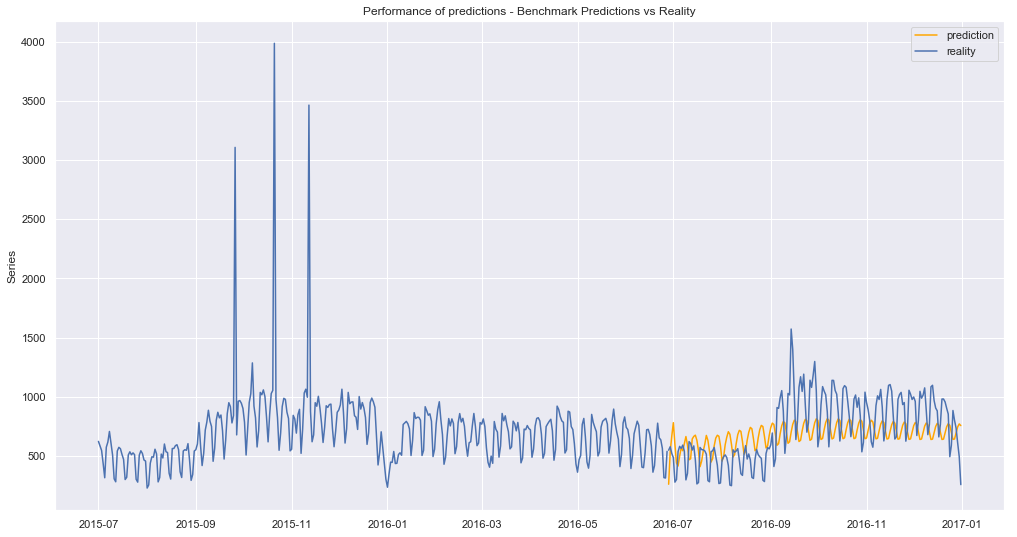

In [54]:
for key in page.columns:
    plot_arima(train[key], test[key], pred[key])

In [55]:
for col in test.columns:
    print ("-----------------------------------------------")
    print('smape for page '+ col + ' is {:10.4f}'.format(smape(test[col], pred[col])))

-----------------------------------------------
smape for page zh is    44.8888
-----------------------------------------------
smape for page es is    43.7087
-----------------------------------------------
smape for page ru is    31.6852


In [56]:
# def perform_var_pred(dataframe):
#     train_size = int(dataframe.shape[0]*0.66)
#     train = dataframe.iloc[0:train_size,:]
#     test = dataframe.iloc[train_size:,:]
#     predictions = pd.DataFrame(columns = dataframe.columns)
#     for t in range(test.shape[0]):
#         model = VAR(train)
#         model_fit = model.fit(maxlags = 10, ic = 'aic')
#         lag_order = model_fit.k_ar
#         yhat = model_fit.forecast(train.values[-lag_order:], steps = 1)
#         predictions = predictions.append(pd.DataFrame(list(yhat), columns = dataframe.columns))
#         train = train.append(test.iloc[t,:])
        
#     #error = mean_squared_error(test.values, predictions.values, multioutput='raw_values')
#     predictions.index = test.index
#     return predictions 

In [57]:
warnings.filterwarnings('ignore')
predictions = perform_var_pred(page)

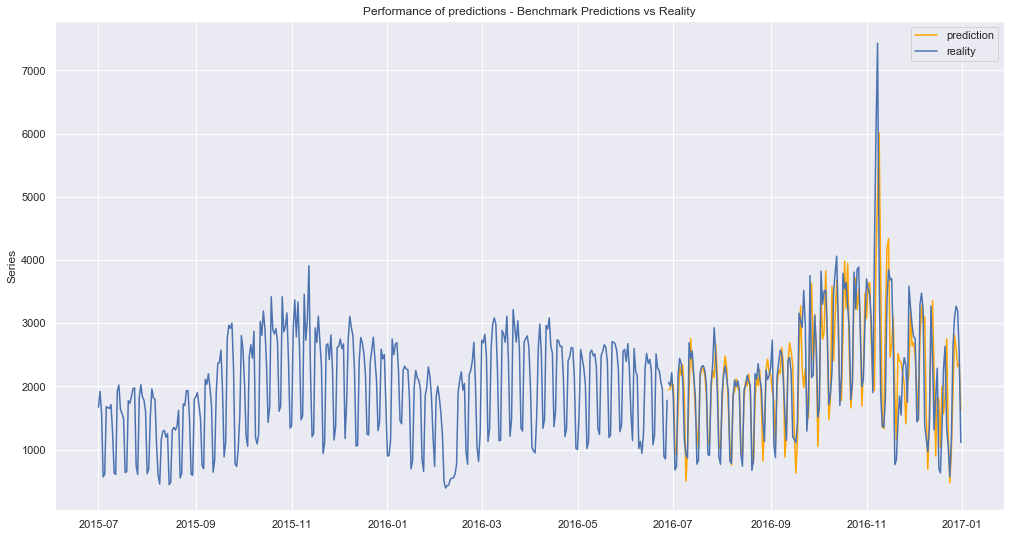

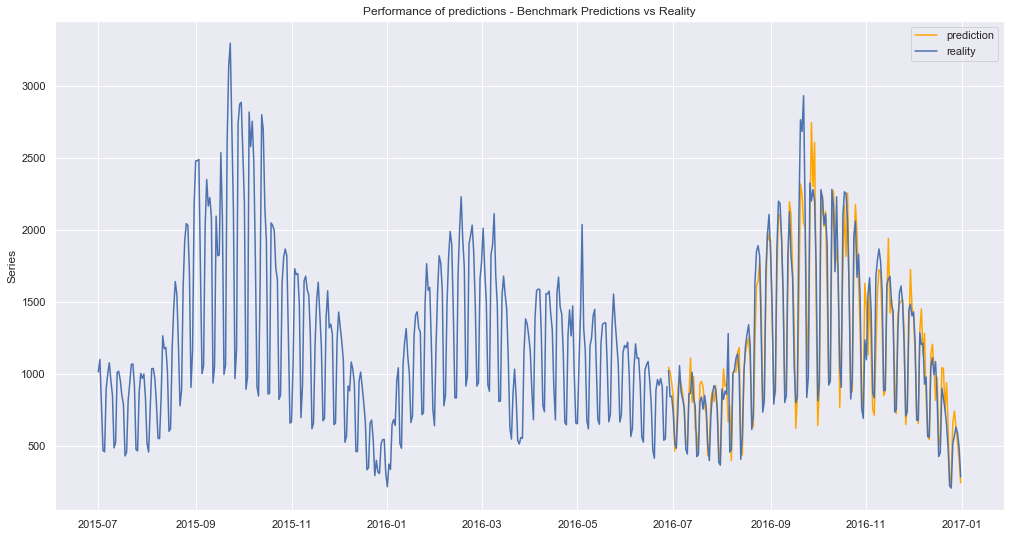

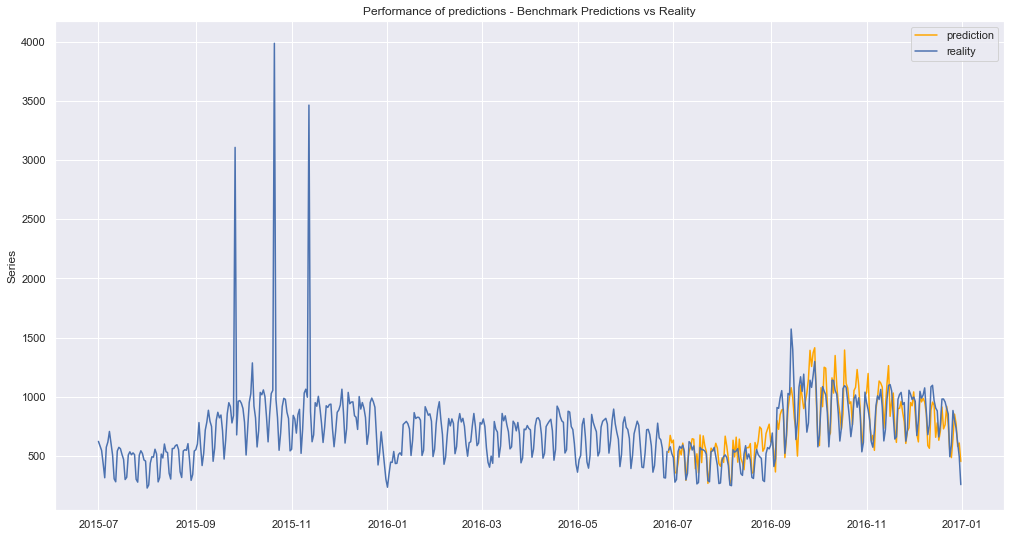

In [58]:
for key in page.columns:
    plot_arima(train[key], test[key], predictions[key])

In [59]:
for col in test.columns:
    print ("-----------------------------------------------")
    print('smape for page '+ col + ' is {:10.4f}'.format(smape(test[col], predictions[col])))

-----------------------------------------------
smape for page zh is    20.5397
-----------------------------------------------
smape for page es is    12.8204
-----------------------------------------------
smape for page ru is    16.1079


In [6]:
from Bayesian import *
import pymc3 as pm

In [7]:
import warnings
warnings.filterwarnings("ignore")
 

the best ar order is 0with a SMAPE of        inf


In [8]:
lags = 7
data = create_lags(ML,lags)


In [37]:
train_size = int(0.66*data.shape[0])
train = data.iloc[:train_size,:]
test = data.iloc[train_size:,:]

import theano 

y = theano.shared(train.iloc[:,0].values.astype('float64'))
x = theano.shared(train.iloc[:,1:].values.astype('float64'))
#x2 = theano.shared(train.iloc[:,2].values.astype('float64'))

In [40]:
#tau = 0.0001

model = pm.Model()
with model:
    
    beta = pm.Uniform('beta',lower = -1, upper = 1,  shape = 7)
    
    sigma_prior = pm.HalfNormal('sigma', sd=100, shape=1)
    mu =theano.tensor.dot(x,beta) 
    #mu = pm.Gamma('mu', mu = theano.tensor.dot(x,beta), sd = sigma_prior)
    y_obs = pm.Normal('y_obs', mu = mu, sd = sigma_prior, observed=y)
    #trace = pm.sample(2000, tune=1000)
    step = pm.ADVI()
    
#     n_draws, n_chains = 3000, 3
#     n_sim = n_draws*n_chains
    
    advi_fit = pm.fit(method=pm.ADVI(), n=40000)
    
    # Consider 3000 draws and 2 chains.
    #advi_trace = pm.sample(draws=n_draws, njobs=n_chains, step = step, tune = 1000)
    
advi_trace = advi_fit.sample(10000)

Average Loss = 2,656.4: 100%|██████████████████████████████████████████████████| 40000/40000 [00:17<00:00, 2351.92it/s]
Finished [100%]: Average Loss = 2,656.5


In [81]:
advi_trace_df = pm.trace_to_dataframe(advi_trace)

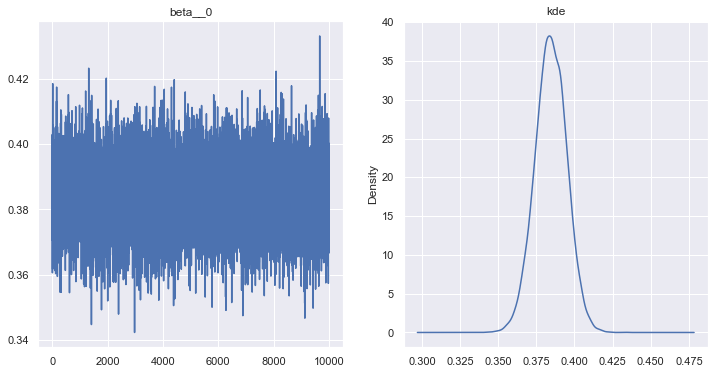

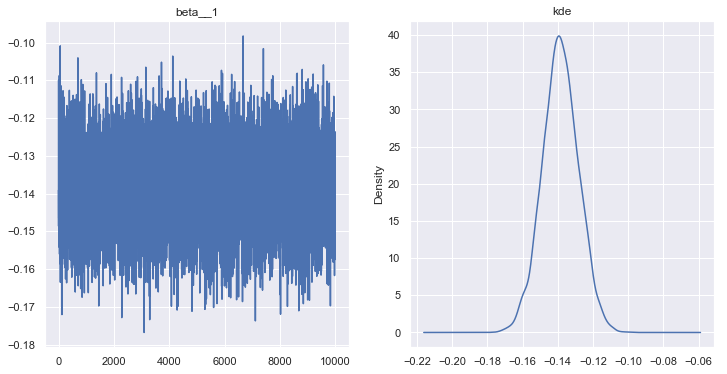

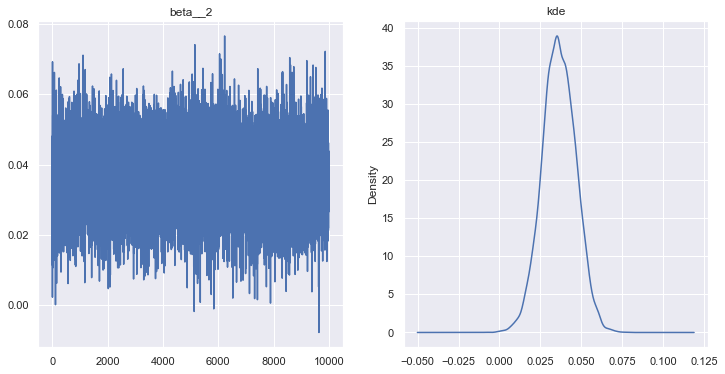

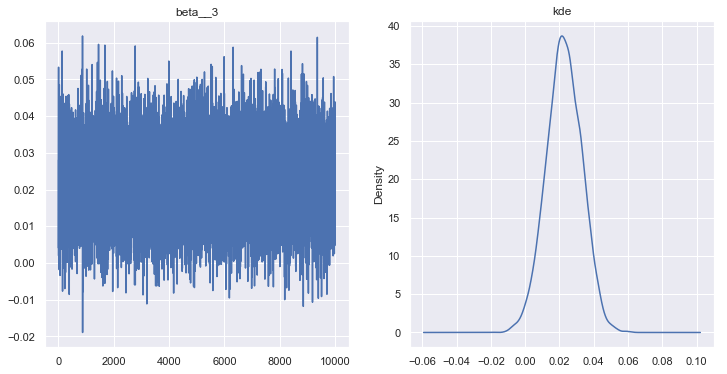

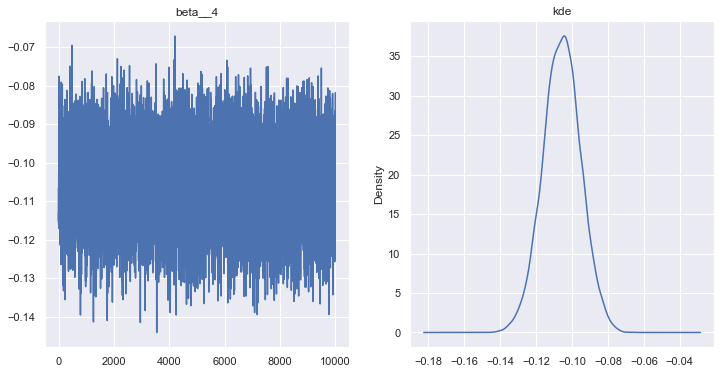

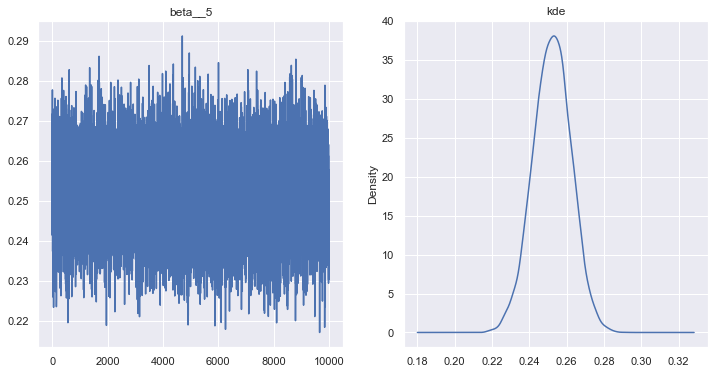

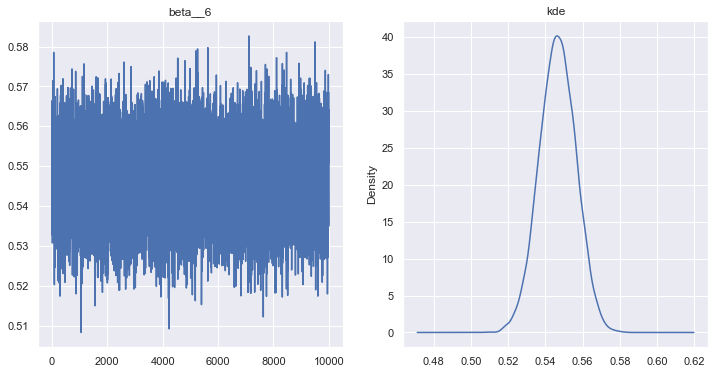

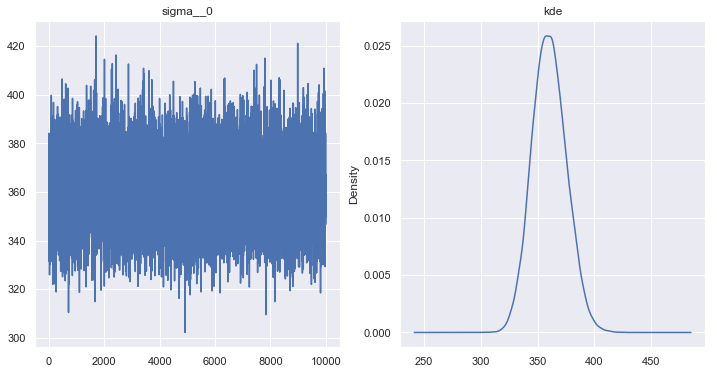

In [82]:
my_trace_plot(advi_trace_df)

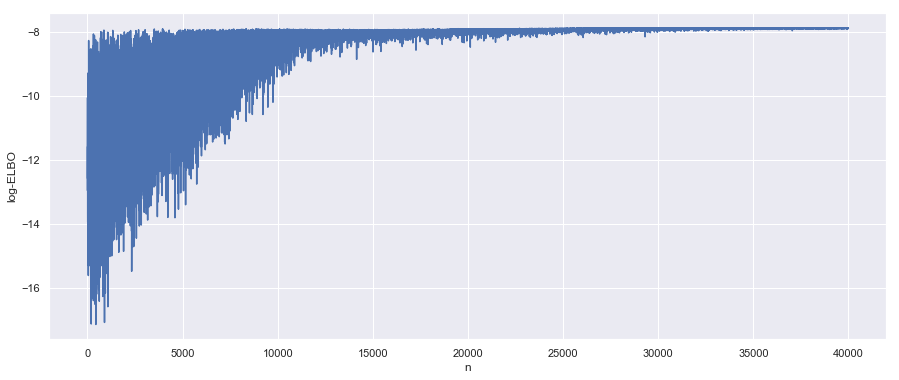

In [11]:
plot_elbo(advi_fit)
plt.show()

In [12]:
pm.stats.summary(advi_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta__0,0.384512,0.010296,0.000098,0.364899,0.405089
beta__1,-0.138461,0.010259,0.000111,-0.160125,-0.119406
beta__2,0.036385,0.010182,0.000091,0.016094,0.055748
beta__3,0.022716,0.010317,0.000094,0.003083,0.043134
beta__4,-0.105722,0.010475,0.000119,-0.127009,-0.085634
beta__5,0.252199,0.010204,0.000097,0.232470,0.272711
beta__6,0.546612,0.009771,0.000094,0.527777,0.565963
sigma__0,360.375081,14.919569,0.158921,331.336906,389.153464


In [41]:
advi_posterior_pred = pm.sample_posterior_predictive(advi_trace, 1000, model)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.83it/s]


In [42]:
advi_predictions = np.mean(advi_posterior_pred['y_obs'], axis=0)

In [43]:
df = pd.DataFrame(
    {'Fitted': advi_predictions, 
     'actual': train.iloc[:,0],
     'error_ADVI': advi_predictions - train.iloc[:,0]})

In [97]:
df.head()

,Predicted,actual,error_ADVI
Date,,,
2016-06-30,3740.920881,3532.0,208.920881
2016-07-01,3061.312142,3015.0,46.312142
2016-07-02,1970.780481,1780.0,190.780481
2016-07-03,1934.792361,1872.0,62.792361
2016-07-04,3060.869847,2988.0,72.869847


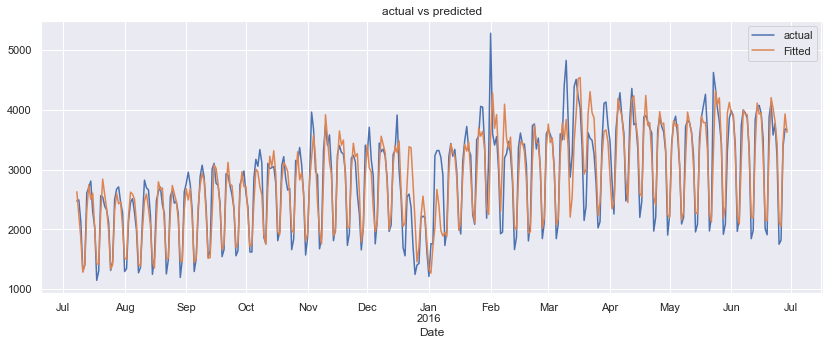

In [45]:
df[['actual', 'Fitted']].plot(figsize=[14,5])
plt.title('actual vs predicted')
plt.show()

In [19]:
smape(df['Predicted'], df['actual'])

9.188589603676716

In [20]:
new = pd.DataFrame(advi_posterior_pred['y_obs'])
new = new.T
new.index = train.index

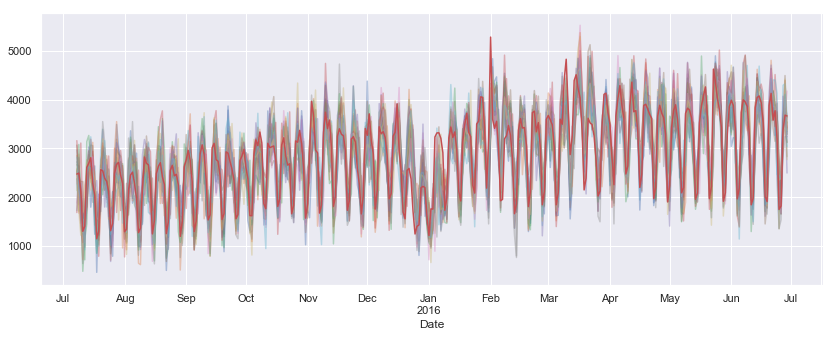

In [24]:
new.iloc[:,:20].plot(legend=False, figsize=[14,5], alpha = 0.4)
train.iloc[:,0].plot(color = 'b')
plt.show()


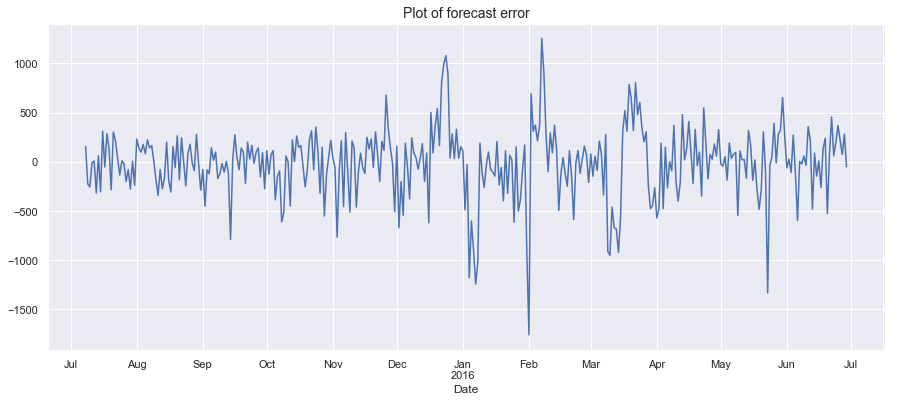

In [25]:
plt.figure(figsize=(15, 6))
df['error_ADVI'].plot()
plt.title('Plot of forecast error', fontsize = 14)
plt.show()

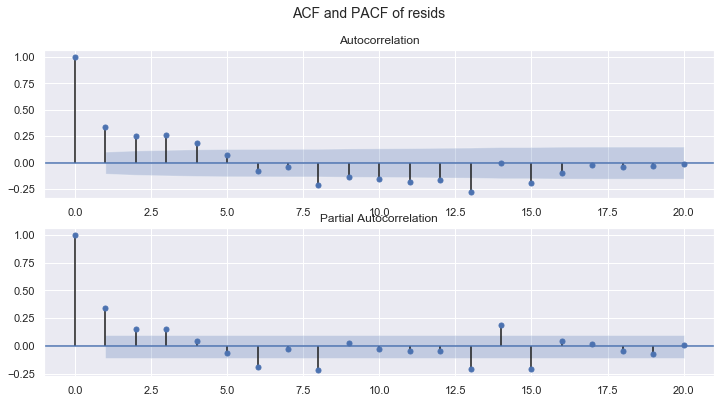

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(12,6))

ax[0] = plot_acf(df['error_ADVI'], lags = 20, ax=ax[0])
ax[1] = plot_pacf(df['error_ADVI'],lags = 20, ax=ax[1])
fig.suptitle('ACF and PACF of resids', fontsize = 14)
plt.show()

In [27]:
#now with test set
y.set_value(test.iloc[:,0].values)
x.set_value(test.iloc[:,1:].values)
advi_posterior_pred = pm.sample_posterior_predictive(advi_trace, 1000, model)
advi_predictions = np.mean(advi_posterior_pred['y_obs'], axis=0)
df = pd.DataFrame(
    {'Predicted': advi_predictions, 
     'actual': test.iloc[:,0],
     'error_ADVI': advi_predictions - test.iloc[:,0]})

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.98it/s]


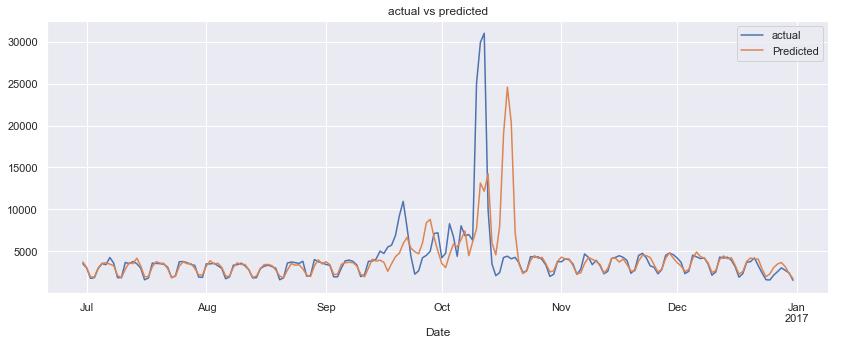

In [28]:
df[['actual', 'Predicted']].plot(figsize=[14,5])
plt.title('actual vs predicted')
plt.show()

In [29]:
smape(df['Predicted'], df['actual'])

17.66432249594135

In [30]:
new = pd.DataFrame(advi_posterior_pred['y_obs'])
new = new.T
new.index = test.index

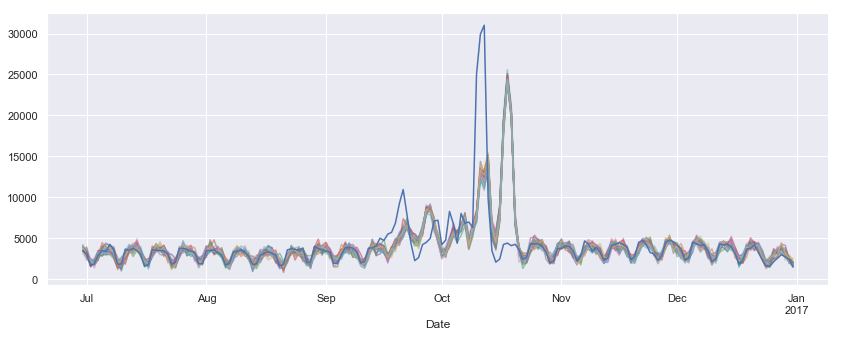

In [31]:
new.iloc[:,:20].plot(legend=False, figsize=[14,5], alpha = 0.6)
test.iloc[:,0].plot()
plt.show()